In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [11]:
kvs = [2 * (bspline.make_knots(1, 0.0, 1.0, 3),)]
geos = [geometry.unit_square()]
patches = [(k, g) for k, g in zip(kvs,geos)]
M = topology.PatchMesh(patches)
M.split_patches();
M.split_patches();

In [12]:
M.geos()[0].bounding_box()

((0.0, 0.25), (0.0, 0.25))

In [4]:
geo=geometry.quarter_annulus(support=((0.5,1.0),(0.5,1.0)))
supp=geo.support
res=50
lcolor="black"
color="grey"
linewidth=2
grid=5

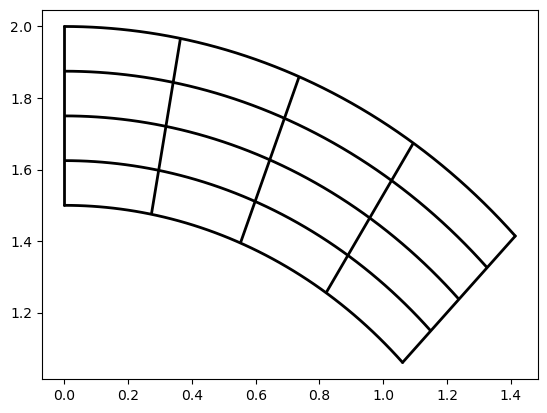

In [5]:
gridx = np.linspace(supp[1][0], supp[1][1], grid)
gridy = np.linspace(supp[0][0], supp[0][1], grid)

meshx = np.linspace(supp[1][0], supp[1][1], res)
meshy = np.linspace(supp[0][0], supp[0][1], res)
    
def plotline(pts, capstyle='butt', color=color, linewidth=None):
    if geo.dim == 3:
        plt.plot(pts[:,0], pts[:,1], pts[:,2], color=lcolor, linewidth=linewidth,
                                       solid_joinstyle='round', solid_capstyle=capstyle)
    if geo.dim == 2:
        plt.plot(pts[:,0], pts[:,1], color=lcolor, linewidth=linewidth,
                solid_joinstyle='round', solid_capstyle=capstyle)

#print(meshy)
pts = utils.grid_eval(geo, (gridy, meshx))
#print(pts)
plotline(pts[0,:,:], capstyle='round', linewidth=linewidth)
for i in range(1, pts.shape[0]-1):
    plotline(pts[i,:,:], linewidth=linewidth)
plotline(pts[-1,:,:], capstyle='round', linewidth=linewidth)

pts = utils.grid_eval(geo, (meshy, gridx))
#print(pts)
plotline(pts[:,0,:], capstyle='round', linewidth=linewidth)
for j in range(1, pts.shape[1]-1):
    plotline(pts[:,j,:], linewidth=linewidth)
plotline(pts[:,-1,:], capstyle='round', linewidth=linewidth)

In [4]:
geo=geometry.quarter_annulus()
supp=geo.support
res=50
lcolor="black"
color="grey"
linewidth=1

In [ ]:
kvs = [2 * (bspline.make_knots(1, 0.0, 1.0, 1),)]
geos = [geometry.unit_square()]
patches = [(k, g) for k, g in zip(kvs,geos)]
M = topology.PatchMesh(patches)
M.split_patches();

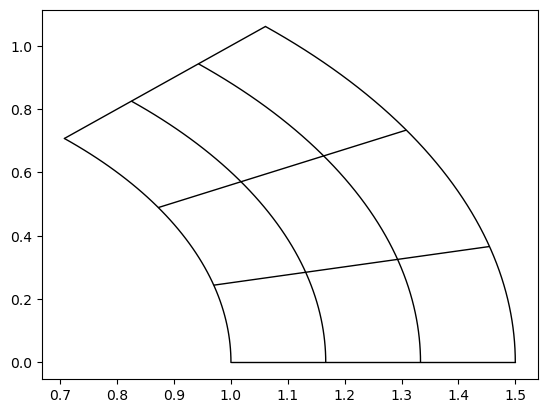

In [5]:
    grid = 4
    gridx = np.linspace(supp[1][0], supp[1][1], grid)
    gridy = np.linspace(supp[0][0], supp[0][1], grid)

    meshx = np.linspace(supp[1][0], supp[1][1], res)
    meshy = np.linspace(supp[0][0], supp[0][1], res)
    
    def plotline(pts, capstyle='butt',color=lcolor):
        plt.plot(pts[:,0], pts[:,1], pts[:,2] , color=lcolor, linewidth=linewidth,
            solid_joinstyle='round', solid_capstyle=capstyle)
        
    def plotline(pts, capstyle='butt', color=color, linewidth=None):
        if geo.dim == 3:
            plt.plot(pts[:,0], pts[:,1], pts[:,2], color=lcolor, linewidth=linewidth,
                                       solid_joinstyle='round', solid_capstyle=capstyle)
        if geo.dim == 2:
            plt.plot(pts[:,0], pts[:,1], color=lcolor, linewidth=linewidth,
                solid_joinstyle='round', solid_capstyle=capstyle)

    #print(meshy)
    pts = utils.grid_eval(geo, (gridx, meshy))
    #print(pts)
    plotline(pts[0,:,:], capstyle='round', linewidth=linewidth)
    for i in range(1, pts.shape[0]-1):
        plotline(pts[i,:,:], linewidth=linewidth)
    plotline(pts[-1,:,:], capstyle='round', linewidth=linewidth)

    pts = utils.grid_eval(geo, (meshx, gridy))
    #print(pts)
    plotline(pts[:,0,:], capstyle='round', linewidth=linewidth)
    for j in range(1, pts.shape[1]-1):
        plotline(pts[:,j,:], linewidth=linewidth)
    plotline(pts[:,-1,:], capstyle='round', linewidth=linewidth)

In [2]:
def drawSkeleton(MP):
    for (p,b,_),(_,_,_),_ in MP.intfs:
        ax,sd=assemble.int_to_bdspec(b)
        geo=MP.mesh.geos()[p]
        kvs=MP.mesh.kvs()[p]
        grid=np.linspace(geo.support[(ax+1)%2][0], geo.support[(ax+1)%2][1],kvs[(ax+1)%2].numdofs)
        if (p,b) == (4,1) or (p,b)==(5,3): grid=grid[1:-1]
        if ax==0:
            Z = geo.eval(grid,np.array([geo.support[0][sd]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd]]),grid)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs()[p], MP.mesh.geos()[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)

In [6]:
2*(bspline.make_knots(2,0,1,2),)

(KnotVector(array([0. , 0. , 0. , 0.5, 1. , 1. , 1. ]), 2),
 KnotVector(array([0. , 0. , 0. , 0.5, 1. , 1. , 1. ]), 2))

In [9]:
patches=[(2*(bspline.make_knots(2,0,1,2),),geometry.unit_square())]
M = topology.PatchMesh(patches)
M.split_patches();
#M.refine({0:None});
M.split_patches({0:None});
M.refine({0:None});
MP=assemble.Multipatch(M, automatch=True)

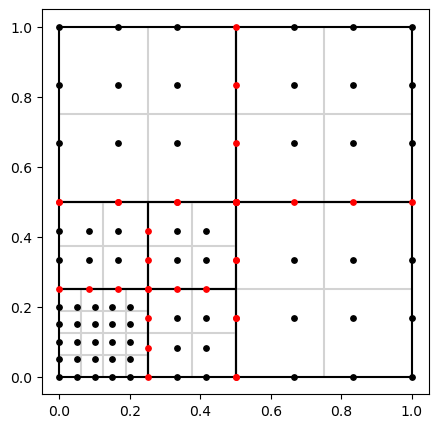

In [10]:
MP.mesh.draw(patch_idx=False)
drawInterior(MP,r=0)
drawSkeleton(MP)

In [6]:
kv1 ,kv2 = bspline.KnotVector(np.array([0.0,0.0,0.25,0.5,0.5]),1), bspline.KnotVector(np.array([0.0,0.0,0.5,0.7,0.8,0.9,1.0,1.0]),1)
bspline.prolongation(kv2,kv1).A

array([[1. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. ]])

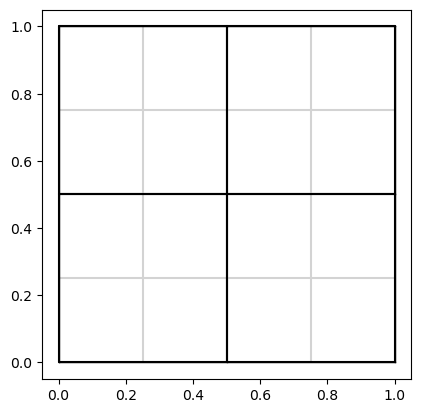

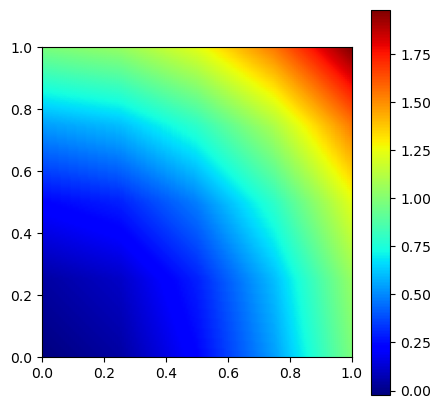

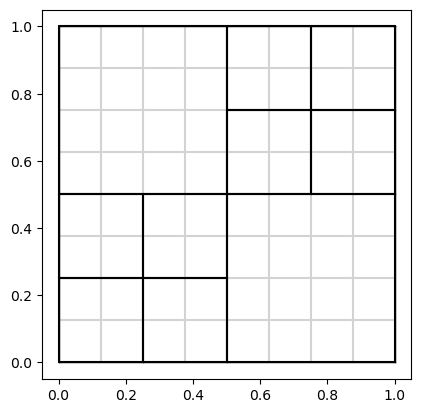

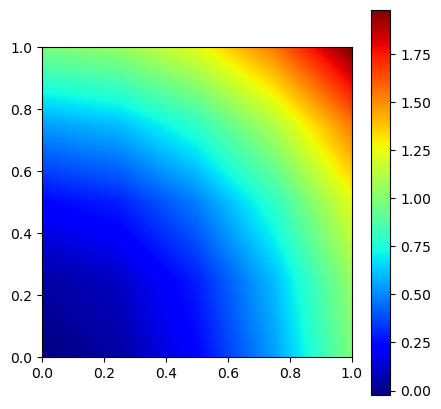

In [2]:
kvs = [2 * (bspline.make_knots(1, 0.0, 1.0, 2),)]
geos = [geometry.unit_square()]
patches = [(k, g) for k, g in zip(kvs,geos)]
M = topology.PatchMesh(patches)
M.split_patches();
MP = assemble.Multipatch(M, automatch=True)
u1 = MP.L2projection(lambda x,y: x**2+y**2)
MP.mesh.draw(plt.figure())
axis('scaled');
MP.plot(u1)
P=MP.patch_refine({0:None,1:-1,2:-1,3:None}, return_P=True)
MP.mesh.draw(plt.figure())
axis('scaled');
MP.plot(P@u1)